In [1]:
import sys
import os
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

from torch.utils.data import DataLoader

sys.path.append('../')

from src.data.hdh.hdh_patches_dataset import HDHPatchesDataset
from src.lightning.lightning_modules.self_supervised.vicreg_simple import VICReg

/home/paulw/anaconda3/envs/exact/lib/python3.9/site-packages/pl_bolts/utils/warnings.py:30: UserWarning: You want to use `gym` which is not installed yet, install it with `pip install gym`.
  stdout_func(


In [2]:
# make empty dataset just to see the tables 
ds = HDHPatchesDataset('../data', [])
ds.all_core_info

,patient_id,core_loc,gleason,core_idx,core_num_for_patient,label,involvement,prostate_volume,psa
0,2001,LML,Benign,0,0,0,0.0,NaN,NaN
1,2001,RBL,Benign,1,1,0,0.0,NaN,NaN
2,2001,RBM,Benign,2,2,0,0.0,NaN,NaN
3,2001,RMM,Benign,3,3,0,0.0,NaN,NaN
4,2001,RA,Benign,4,4,0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
661,2099,LMM,3+4,661,1,1,0.2,21.0,5.0
662,2099,LA,Benign,662,2,0,0.0,21.0,5.0
663,2099,RBL,Benign,663,3,0,0.0,21.0,5.0
664,2099,RML,Benign,664,4,0,0.0,21.0,5.0


In [3]:
# we generate splits based on patients
all_patient_ids = ds.all_core_info.patient_id.unique()

from sklearn.model_selection import train_test_split
train_patient_ids, test_patient_ids = train_test_split(all_patient_ids, test_size=0.2, random_state=42)

# further divide the train set into train and validation
train_patient_ids, val_patient_ids = train_test_split(train_patient_ids, test_size=0.2, random_state=42)

# now we get the core indices for each split
train_core_indices = ds.all_core_info.query('patient_id in @train_patient_ids').core_idx.values
val_core_indices = ds.all_core_info.query('patient_id in @val_patient_ids').core_idx.values
test_core_indices = ds.all_core_info.query('patient_id in @test_patient_ids').core_idx.values

In [4]:
# We need to select the augmentations for VICReg
from src.data.exact.transforms import TransformV3, Normalize, TensorImageAugmentation, MultiTransform

basic_transform = TransformV3() # just normalize and create tensor

augmentations = TransformV3(tensor_transform=TensorImageAugmentation(
    random_erasing=False, 
    random_invert=True, 
    random_horizontal_flip=True, 
    random_vertical_flip=True,
    random_affine_rotation=False, 
    random_affine_translation=[0, 0], 
    random_resized_crop=True, 
    random_resized_crop_scale=[0.5, 1]
))  # augmentations

augmentations_pair = MultiTransform(augmentations, augmentations)   # augmentations for pairs

def target_transform(target):
    return torch.tensor(target, dtype=torch.long)

In [5]:
# Now we can create the datasets for each split

train_ds = HDHPatchesDataset('../data', train_core_indices, basic_transform, target_transform)
train_ds_ssl = HDHPatchesDataset('../data', train_core_indices, augmentations_pair, target_transform)
val_ds = HDHPatchesDataset('../data', val_core_indices, basic_transform, target_transform=target_transform)
val_ds_ssl = HDHPatchesDataset('../data', val_core_indices, augmentations_pair, target_transform=target_transform)
test_ds = HDHPatchesDataset('../data', test_core_indices, basic_transform, target_transform=target_transform)

In [6]:
# datasets include patch info tables with useful information: 
train_ds.data_table.head()

,patient_id,core_num_for_patient,patch_num_for_core,fpath,core_loc,gleason,core_idx,label,involvement,prostate_volume,psa
0,2002,0,0,../data/HDH_patches/bm_coor_oriented/P2002_c0_...,LBM,Benign,5,0,0.0,NaN,NaN
1,2002,0,1,../data/HDH_patches/bm_coor_oriented/P2002_c0_...,LBM,Benign,5,0,0.0,NaN,NaN
2,2002,0,2,../data/HDH_patches/bm_coor_oriented/P2002_c0_...,LBM,Benign,5,0,0.0,NaN,NaN
3,2002,0,3,../data/HDH_patches/bm_coor_oriented/P2002_c0_...,LBM,Benign,5,0,0.0,NaN,NaN
4,2002,0,4,../data/HDH_patches/bm_coor_oriented/P2002_c0_...,LBM,Benign,5,0,0.0,NaN,NaN


Text(0.5, 1.0, 'Second augmentation')

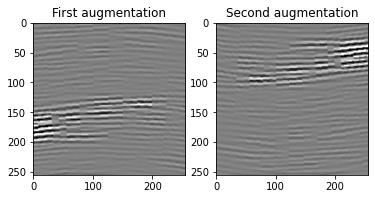

In [7]:
# look at a sample from the ssl train set
(X1, X2), y, _= train_ds_ssl[0]
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X1[0], cmap='gray')
ax2.imshow(X2[0], cmap='gray')
ax1.set_title('First augmentation')
ax2.set_title('Second augmentation')


In [8]:
# create our self-supervised dataloaders: 
train_dl_ssl = DataLoader(train_ds_ssl, batch_size=64, shuffle=True, num_workers=4)
val_dl_ssl = DataLoader(val_ds_ssl, batch_size=64, shuffle=False, num_workers=4)

# create our supervised dataloaders:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=4)


In [9]:
# bring in the feature extractor
from src.modeling.registry import create_model
model = create_model('resnet10_feature_extractor')

In [10]:
# test a forward pass
batch = next(iter(train_dl_ssl))
(X1, X2), y, _ = batch
feats = model(X1)
feats.shape

torch.Size([64, 512])

In [11]:
# VICReg pytorch lightning module defines training and validation steps
from src.lightning.lightning_modules.self_supervised.vicreg_simple import VICReg

# create the lightning module
vicreg = VICReg(
    model,
    proj_output_dim=512, 
    proj_hidden_dim=512, 
    lr=1e-3,
)

In [12]:
# create pytorch lightning logger
from pytorch_lightning.loggers import CSVLogger
logger = CSVLogger('logs', name='vicreg')

In [13]:
# add some simple callbacks
from pytorch_lightning.callbacks.lr_monitor import LearningRateMonitor

# log the learning rate alongside metrics, helps debug learning rate schedulers
lr_monitor = LearningRateMonitor()
callbacks = [lr_monitor]

In [14]:
# create pytorch lightning trainer
trainer = pl.Trainer(
    gpus=1,
    max_epochs=100, 
    logger=logger,
)

# train the model
trainer.fit(vicreg, train_dl_ssl, val_dl_ssl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/paulw/anaconda3/envs/exact/lib/python3.9/site-packages/pytorch_lightning/core/optimizer.py:380: RuntimeWarning: Found unsupported keys in the optimizer configuration: {'interval'}
  rank_zero_warn(

  | Name      | Type       | Params
-----------------------------------------
0 | backbone  | ResNet     | 4.9 M 
1 | projector | Sequential | 526 K 
-----------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.703    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [19]:
resnet_weights = vicreg.backbone.state_dict()

In [20]:
# finetune the model on the supervised dataset
from torchmetrics import Accuracy, AUROC

class Finetuner(pl.LightningModule): 
    def __init__(self, backbone, lr=1e-3, freeze_backbone=False):
        super().__init__()
        self.backbone = backbone
        self.freeze_backbone = freeze_backbone
        self.lr = lr
        self.classifier = nn.Linear(512, 2)
        self.train_acc = Accuracy(average='macro', num_classes=2)
        self.train_auroc = AUROC(num_classes=2)
        self.val_acc = Accuracy(average='macro', num_classes=2)
        self.val_auroc = AUROC(num_classes=2)
        self.test_acc = Accuracy(average='macro', num_classes=2)
        self.test_auroc = AUROC(num_classes=2)

    def on_train_epoch_start(self) -> None:
        if self.freeze_backbone:
            self.backbone.eval()

    def forward(self, x):
        with torch.no_grad() if self.freeze_backbone else torch.enable_grad():
            x = self.backbone(x)
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss)
        self.log('train_acc', self.train_acc(y_hat, y))
        self.log('train_auroc', self.train_auroc(y_hat, y))
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', loss)
        self.log('val_acc', self.val_acc(y_hat, y))
        self.log('val_auroc', self.val_auroc(y_hat, y))
        return loss

    def test_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self(x)

        loss = F.cross_entropy(y_hat, y)
        self.log('test_loss', loss)
        self.log('test_acc', self.test_acc(y_hat, y))
        self.log('test_auroc', self.test_auroc(y_hat, y))
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


vicreg.backbone.load_state_dict(resnet_weights)
supervised_module = Finetuner(vicreg.backbone, lr=1e-4, freeze_backbone=False)

# create pytorch lightning logger
from pytorch_lightning.loggers import CSVLogger

logger = CSVLogger('logs', name='supervised')

from pytorch_lightning.callbacks.lr_monitor import LearningRateMonitor
from pytorch_lightning.callbacks import EarlyStopping
callbacks = [LearningRateMonitor()]

trainer = pl.Trainer(
    gpus=1,
    max_epochs=100,
    logger=logger, 
    callbacks=callbacks,
)

trainer.fit(supervised_module, train_dl, val_dl)

/home/paulw/anaconda3/envs/exact/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type     | Params
-----------------------------------------
0 | backbone    | ResNet   | 4.9 M 
1 | classifier  | Linear   | 1.0 K 
2 | train_acc   | Accuracy | 0     
3 | train_auroc | AUROC    | 0     
4 | val_acc     | Accuracy | 0     
5 | val_auroc   | AUROC    | 0     
6 | test_acc    | Accuracy | 0     
7 | test_auroc  | AUROC    | 0     
-----------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params
19.602    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/paulw/anaconda3/envs/exact/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/home/paulw/anaconda3/envs/exact/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

<AxesSubplot:xlabel='step', ylabel='val_acc'>

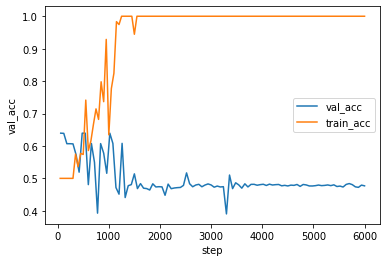

In [29]:
data = pd.read_csv('logs/supervised/version_7/metrics.csv').sort_values(by='step')
import seaborn as sns
sns.lineplot(data=data, x='step', y='val_acc', label='val_acc')
sns.lineplot(data=data, x='step', y='train_acc', label='train_acc')